In [ ]:
from google.colab import files
import os
os.mkdir("road_signs")
os.chdir("road_signs")

In [ ]:
files.upload()

Saving archive.zip to archive.zip


In [ ]:
import os
import zipfile

local_zip = '/content/road_signs/archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/road_signs/')
zip_ref.close()

In [ ]:
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
images_path = Path('./road_signs/images')
anno_path = Path('./road_signs/annotations')

In [ ]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [ ]:
df_train = generate_train_df(anno_path)

In [ ]:
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [ ]:
print(df_train.shape)
df_train.head()

(877, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,road_signs/images/road205.png,300,400,2,149,178,259,287
1,road_signs/images/road8.png,400,300,3,91,72,129,136
2,road_signs/images/road158.png,300,400,2,168,112,225,170
3,road_signs/images/road149.png,400,222,2,123,36,277,158
4,road_signs/images/road362.png,300,400,0,82,164,151,232


In [ ]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [ ]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

In [ ]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [ ]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('./road_signs/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

In [ ]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

(400, 300, 3)


In [ ]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([125., 111., 149., 134.], dtype=float32)

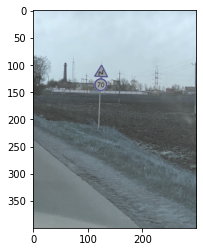

In [ ]:
plt.imshow(im)

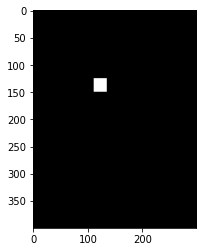

In [ ]:
plt.imshow(Y, cmap='gray')

In [ ]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [ ]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [ ]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [ ]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [ ]:
df_train.values[68][8]

'road_signs/images_resized/road203.png'

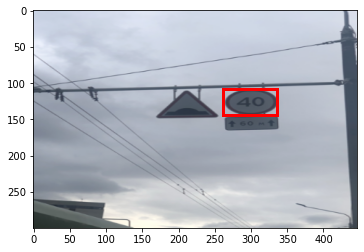

In [ ]:
#original
im = cv2.imread(df_train.values[68][8])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[68][9])

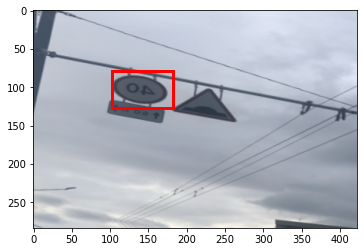

In [ ]:
# after transformation
im, bb = transformsXY(str(df_train.values[68][8]),df_train.values[68][9],True )
show_corner_bb(im, bb)

In [ ]:
df_train = df_train.reset_index()

In [ ]:
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [ ]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [ ]:
train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)


In [ ]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [ ]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [ ]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [ ]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("Epochs %f train_loss %.3f val_loss %.3f val_acc %.3f" % (i, train_loss, val_loss, val_acc))
    return sum_loss/total

In [ ]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [ ]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=100)

Epochs 0.000000 train_loss 2.634 val_loss 238478.676 val_acc 0.091
Epochs 1.000000 train_loss 1.656 val_loss 29.849 val_acc 0.205
Epochs 2.000000 train_loss 1.448 val_loss 6.389 val_acc 0.386
Epochs 3.000000 train_loss 1.247 val_loss 1.541 val_acc 0.744
Epochs 4.000000 train_loss 1.092 val_loss 1.100 val_acc 0.778
Epochs 5.000000 train_loss 0.989 val_loss 1.373 val_acc 0.670
Epochs 6.000000 train_loss 0.900 val_loss 0.819 val_acc 0.807
Epochs 7.000000 train_loss 0.864 val_loss 0.936 val_acc 0.756
Epochs 8.000000 train_loss 0.875 val_loss 1.309 val_acc 0.608
Epochs 9.000000 train_loss 0.880 val_loss 1.138 val_acc 0.716
Epochs 10.000000 train_loss 0.915 val_loss 1.817 val_acc 0.449
Epochs 11.000000 train_loss 0.845 val_loss 1.094 val_acc 0.699
Epochs 12.000000 train_loss 0.783 val_loss 0.811 val_acc 0.784
Epochs 13.000000 train_loss 0.746 val_loss 1.663 val_acc 0.540
Epochs 14.000000 train_loss 0.783 val_loss 1.077 val_acc 0.778
Epochs 15.000000 train_loss 0.721 val_loss 1.003 val_acc 0.

0.4284092172576425

In [ ]:
update_optimizer(optimizer, 0.001)
train_epocs(model, optimizer, train_dl, valid_dl, epochs=100)

Epochs 0.000000 train_loss 0.455 val_loss 0.652 val_acc 0.875
Epochs 1.000000 train_loss 0.439 val_loss 0.634 val_acc 0.886
Epochs 2.000000 train_loss 0.332 val_loss 0.682 val_acc 0.864
Epochs 3.000000 train_loss 0.323 val_loss 0.652 val_acc 0.864
Epochs 4.000000 train_loss 0.309 val_loss 0.647 val_acc 0.869
Epochs 5.000000 train_loss 0.296 val_loss 0.634 val_acc 0.864
Epochs 6.000000 train_loss 0.277 val_loss 0.617 val_acc 0.886
Epochs 7.000000 train_loss 0.276 val_loss 0.626 val_acc 0.875
Epochs 8.000000 train_loss 0.258 val_loss 0.640 val_acc 0.869
Epochs 9.000000 train_loss 0.261 val_loss 0.621 val_acc 0.875
Epochs 10.000000 train_loss 0.263 val_loss 0.626 val_acc 0.886
Epochs 11.000000 train_loss 0.256 val_loss 0.649 val_acc 0.864
Epochs 12.000000 train_loss 0.242 val_loss 0.627 val_acc 0.875
Epochs 13.000000 train_loss 0.250 val_loss 0.666 val_acc 0.869
Epochs 14.000000 train_loss 0.293 val_loss 0.714 val_acc 0.847
Epochs 15.000000 train_loss 0.241 val_loss 0.700 val_acc 0.835
Ep

0.12163756611343797

In [55]:
X_val

,new_path,new_bb
710,road_signs/images_resized/road254.png,"[54.0, 160.0, 90.0, 232.0]"
734,road_signs/images_resized/road474.png,"[132.0, 215.0, 161.0, 278.0]"
244,road_signs/images_resized/road63.png,"[28.0, 147.0, 253.0, 372.0]"
231,road_signs/images_resized/road173.png,"[69.0, 81.0, 131.0, 202.0]"
291,road_signs/images_resized/road818.png,"[123.0, 197.0, 201.0, 350.0]"
...,...,...
500,road_signs/images_resized/road507.png,"[118.0, 93.0, 182.0, 223.0]"
215,road_signs/images_resized/road438.png,"[195.0, 48.0, 227.0, 113.0]"
350,road_signs/images_resized/road851.png,"[88.0, 168.0, 104.0, 199.0]"
81,road_signs/images_resized/road378.png,"[126.0, 111.0, 220.0, 298.0]"


In [58]:
# resizing test image
im = read_image('./road_signs/images_resized/road789.png')
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite('./road_signs/road_signs_test/road789.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [59]:
# test Dataset
test_ds = RoadDataset(pd.DataFrame([{'path':'./road_signs/road_signs_test/road789.jpg'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

In [60]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 423])

In [61]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 9.4949, -3.4389, -4.5132, -5.6080]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[130.2496, 160.3541, 172.7798, 236.1386]], device='cuda:0',
        grad_fn=<AddmmBackward0>))

In [62]:
# predicted class
torch.max(out_class, 1)

torch.return_types.max(values=tensor([9.4949], device='cuda:0', grad_fn=<MaxBackward0>), indices=tensor([0], device='cuda:0'))

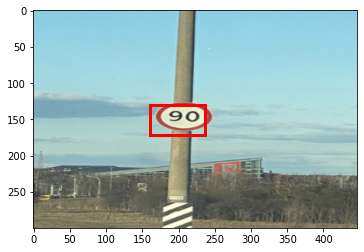

In [63]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])